## Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import mysql.connector
import re
import nltk
import joblib
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Bidirectional, Dense
from keras_tuner import RandomSearch, Hyperband
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
import spacy
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Fetch News Data

In [5]:
# Fetch news data from MySQL
def fetch_news_from_mysql():
    try:
        conn = mysql.connector.connect(
            host='localhost',
            user='root',
            password='Ariyarathne99@',
            database='crypto_news'
        )
        query = "SELECT date, headline, description FROM ethereum_news"
        news_data = pd.read_sql_query(query, conn)
        conn.close()
        return news_data
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

news_data = fetch_news_from_mysql()

C:\Users\acer\AppData\Local\Temp\ipykernel_8748\4279475153.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  news_data = pd.read_sql_query(query, conn)


In [6]:
news_data

,date,headline,description
0,"Jan 10, 2025","Grayscale Adjusts Fund Holdings, 90% Allocatio...",Grayscale Investments announced adjustments to...
1,"Jan 08, 2025","Bhutan’s ‘Mindfulness City’ Includes BNB, BTC,...",Bhutan’s Gelephu Mindfulness City has become o...
2,"Dec 29, 2024",US Spot Bitcoin ETFs See Over $35B in Inflows ...,Spot Bitcoin ETFs in the United States recorde...
3,"Dec 19, 2024",Bitcoin and Ether Spot ETFs See Two Weeks of I...,Bitcoin and Ethereum spot exchange-traded fund...
4,"Dec 16, 2024","Bitcoin Soars Past $106,000 Amid Hopes of U.S....","Bitcoin surged to an all-time high above $106,..."
...,...,...,...
5172,"Mar 06, 2025",Medical Tech Firm BioNexus Gene Lab Announces ...,Healthcare technology company BioNexus Gene La...
5173,"Mar 05, 2025",Ethereum’s Pectra Upgrade Goes Live on Sepolia...,Ethereum’s Pectra upgrade has successfully gon...
5174,"Mar 14, 2025",Bybit CEO Questions DEXs’ Risk Controls After ...,Bybit CEO Ben Zhou has raised concerns about d...
5175,"Mar 11, 2025",Thailand SEC Approves USDT for Trading and Pay...,Thailand has taken a significant step forward ...


## Preprocess News Data

In [8]:
# Load spaCy NLP model (efficient lemmatization)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Load Loughran-McDonald Finance Sentiment Dictionary
lm_positive = {    "gain", "growth", "bullish", "opportunity", "profit", "surge", "expansion",
    "adoption", "approval", "partnership", "innovation", "mainstream", "rally",
    "institutional", "breakthrough", "stability", "strong", "all-time-high",
    "liquidity", "halving", "scarcity", "whale accumulation", "stake", "integration",
    "etf approval", "layer 2 scaling", "metaverse expansion", "positive outlook"}

lm_negative = {"crash", "loss", "bearish", "decline", "debt", "bankruptcy", "downturn",
    "regulatory crackdown", "ban", "fud", "lawsuit", "hacked", "ponzi",
    "liquidation", "fraud", "scam", "rug pull", "dumping", "sell-off",
    "volatility", "delisting", "depeg", "inflation", "recession", "exchange insolvency",
    "crypto winter", "negative outlook"}

def preprocess_text(text):
    """Cleans, removes stopwords, and lemmatizes input text."""
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  
    text = re.sub(r"[^a-zA-Z\s]", "", text)  
    text = re.sub(r"\s+", " ", text).strip()  
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

def financial_sentiment_adjustment(text, vader_score):
    """Adjust sentiment score using the Loughran-McDonald financial lexicon."""
    words = text.split()
    adjustment = sum(0.2 if word in lm_positive else -0.2 if word in lm_negative else 0 for word in words)
    return max(min(vader_score + adjustment, 1), -1)

def preprocess_news(news_data):
    """Preprocess news headlines & descriptions, and extract sentiment scores."""
    news_data["cleaned_headline"] = news_data["headline"].astype(str).apply(preprocess_text)
    news_data["cleaned_description"] = news_data["description"].astype(str).apply(preprocess_text)

    analyzer = SentimentIntensityAnalyzer()
    news_data["VADER_Headline_Sentiment"] = news_data["cleaned_headline"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
    news_data["VADER_Description_Sentiment"] = news_data["cleaned_description"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

    news_data["Final_Headline_Sentiment"] = news_data.apply(
        lambda row: financial_sentiment_adjustment(row["cleaned_headline"], row["VADER_Headline_Sentiment"]), axis=1
    )
    news_data["Final_Description_Sentiment"] = news_data.apply(
        lambda row: financial_sentiment_adjustment(row["cleaned_description"], row["VADER_Description_Sentiment"]), axis=1
    )

    news_data["date"] = pd.to_datetime(news_data["date"], errors="coerce")
    return news_data[["date", "Final_Headline_Sentiment", "Final_Description_Sentiment"]].drop_duplicates()

news_data = preprocess_news(news_data)
news_data = news_data.groupby('date', as_index=False).mean()


In [9]:
news_data

,date,Final_Headline_Sentiment,Final_Description_Sentiment
0,2018-01-18,0.000000,-0.20000
1,2018-01-22,-0.571900,-0.10270
2,2018-01-24,0.726700,0.62150
3,2018-01-25,0.000000,0.36120
4,2018-01-26,-0.051600,0.38180
...,...,...,...
1875,2025-03-07,0.210750,0.00000
1876,2025-03-08,0.088950,0.50925
1877,2025-03-11,-0.175020,0.18480
1878,2025-03-13,0.132775,0.00830


## Fetch crypto price data

In [13]:
symbol = 'ETH-USD'
interval = '1d'
start_date = '2020-07-27'
end_date = datetime.today().strftime('%Y-%m-%d')

price_data = yf.download(symbol, start=start_date, end=end_date, interval=interval)
price_data.reset_index(inplace=True)
price_data['Date'] = pd.to_datetime(price_data['Date']).dt.date
price_data = price_data.sort_index()
price_data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [14]:
price_data

,Date,Close,High,Low,Open,Volume
0,2020-07-27,321.514099,330.701202,309.657928,309.657928,15644257058
1,2020-07-28,316.657257,325.905975,307.721344,321.829742,12357108065
2,2020-07-29,318.190887,324.380798,313.109589,316.555359,10878845706
3,2020-07-30,334.586639,338.631195,315.751099,318.144989,11827689045
4,2020-07-31,345.554657,348.611359,329.340942,334.633728,12030600492
...,...,...,...,...,...,...
1688,2025-03-11,1919.844971,1961.797729,1760.941772,1859.777710,30898385863
1689,2025-03-12,1908.982666,1954.571167,1832.019043,1919.664795,22898872951
1690,2025-03-13,1862.969604,1919.688232,1823.525391,1909.015381,17977225564
1691,2025-03-14,1909.467529,1945.091431,1861.105957,1862.997925,12122715282


In [15]:
news_data.rename(columns={'date': 'Date'}, inplace=True)
price_data['Date'] = pd.to_datetime(price_data['Date'], errors='coerce')
news_data['Date'] = pd.to_datetime(news_data['Date'])
price_data['Date'] = price_data['Date'].dt.tz_localize(None)

In [16]:
# Merge news and price data
merged_data = pd.merge(news_data, price_data, on='Date', how='right')
merged_data.fillna(method='ffill', inplace=True)
merged_data.drop(columns=['Final_Headline_Sentiment', 'Volume', 'High', 'Low', 'Open'], inplace=True)

C:\Users\acer\AppData\Local\Temp\ipykernel_8748\1422718129.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)


In [17]:
merged_data

,Date,Final_Description_Sentiment,Sentiment_Category,Close
0,2020-07-27,0.188275,Positive,321.514099
1,2020-07-28,0.346167,Positive,316.657257
2,2020-07-29,0.682400,Positive,318.190887
3,2020-07-30,0.546000,Positive,334.586639
4,2020-07-31,1.000000,Positive,345.554657
...,...,...,...,...
1688,2025-03-11,0.184800,Negative,1919.844971
1689,2025-03-12,0.184800,Negative,1908.982666
1690,2025-03-13,0.008300,Positive,1862.969604
1691,2025-03-14,-0.337200,Negative,1909.467529


## Model Development with hypeparameter tuning

In [19]:
# Define window size
window_size = 2

def create_sequences(data, window_size):
    """Create sequences of past prices for training."""
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [20]:
# Prepare dataset
input_features = merged_data[['Final_Description_Sentiment', 'Close']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(input_features)

X, y = create_sequences(scaled_data[:, 1], window_size)
sentiment_data = scaled_data[window_size:, 0].reshape(-1, 1)
X = np.concatenate((X, sentiment_data), axis=1)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [21]:
from tensorflow.keras.layers import LSTM

# LSTM Model
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('lstm_units_1', 32, 128, 32), return_sequences=True, input_shape=(window_size + 1, 1)))
    model.add(Dropout(rate=hp.Float('dropout_1', 0.1, 0.5, 0.1)))
    model.add(LSTM(units=hp.Int('lstm_units_2', 16, 64, 16), return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout_2', 0.1, 0.5, 0.1)))
    model.add(Dense(units=1))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# Hyperparameter tuning for LSTM model
tuner_lstm = kt.Hyperband(build_lstm_model, objective='val_loss', max_epochs=50, factor=3, directory='keras_tuner', project_name='lstm_tuning_d')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

C:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
# Search for best hyperparameters
tuner_lstm.search(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping, reduce_lr])

# Retrieve best model
best_lstm_model = tuner_lstm.get_best_models(num_models=1)[0]

best_lstm_model.save('best_model_D_lstm.h5')

Trial 90 Complete [00h 00m 25s]
val_loss: 0.0014663479523733258

Best val_loss So Far: 0.0008570255013182759
Total elapsed time: 00h 20m 42s


In [23]:
# Get the best hyperparameters
best_hps = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameter values
print(f"Best LSTM Units Layer 1: {best_hps.get('lstm_units_1')}")
print(f"Best LSTM Units Layer 2: {best_hps.get('lstm_units_2')}")
print(f"Best Dropout Rate Layer 1: {best_hps.get('dropout_1')}")
print(f"Best Dropout Rate Layer 2: {best_hps.get('dropout_2')}")
print(f"Best Optimizer: {best_hps.get('optimizer')}")


Best LSTM Units Layer 1: 128
Best LSTM Units Layer 2: 64
Best Dropout Rate Layer 1: 0.2
Best Dropout Rate Layer 2: 0.2
Best Optimizer: adam


In [24]:
# Save scaler
joblib.dump(scaler, 'scaler_LD.pkl')

['scaler_LD.pkl']

## Error Analysis

In [26]:
# Load the best saved GRU model and scaler
best_model = tf.keras.models.load_model('best_model_D_lstm.h5')
scaler = joblib.load('scaler_LD.pkl')

# Make predictions on test data
y_pred_scaled = best_model.predict(X_test)

# Reverse scale the predictions
y_pred = scaler.inverse_transform(np.hstack((np.zeros((y_pred_scaled.shape[0], 1)), y_pred_scaled)))[:, 1]
y_test_actual = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], 1)), y_test.reshape(-1, 1))))[:, 1]

# Create a DataFrame for visualization
error_df = pd.DataFrame({
    'Date': merged_data['Date'].iloc[-len(y_test):].values,
    'Actual': y_test_actual,
    'Predicted': y_pred
})


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


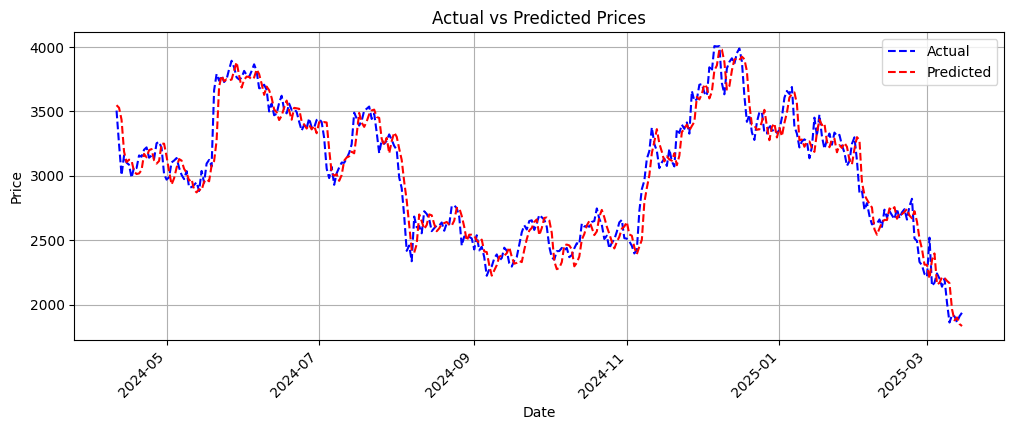

In [27]:
# Plot Actual vs Predicted prices
plt.figure(figsize=(12, 4))
plt.plot(error_df['Date'], error_df['Actual'], label='Actual', color='blue', linestyle='dashed')
plt.plot(error_df['Date'], error_df['Predicted'], label='Predicted', color='red', linestyle='dashed')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Actual vs Predicted Prices')
plt.legend()
plt.grid()
plt.show()

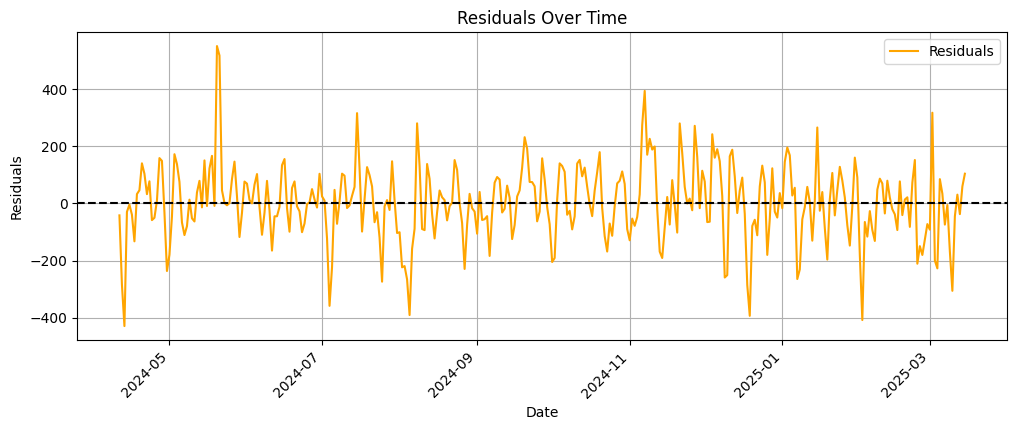

In [28]:
# Compute residuals
error_df['Residuals'] = error_df['Actual'] - error_df['Predicted']

# Plot Residuals Over Time
plt.figure(figsize=(12, 4))
plt.plot(error_df['Date'], error_df['Residuals'], color='orange', label='Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.legend()
plt.grid()
plt.xticks(rotation=45, ha='right')
plt.show()


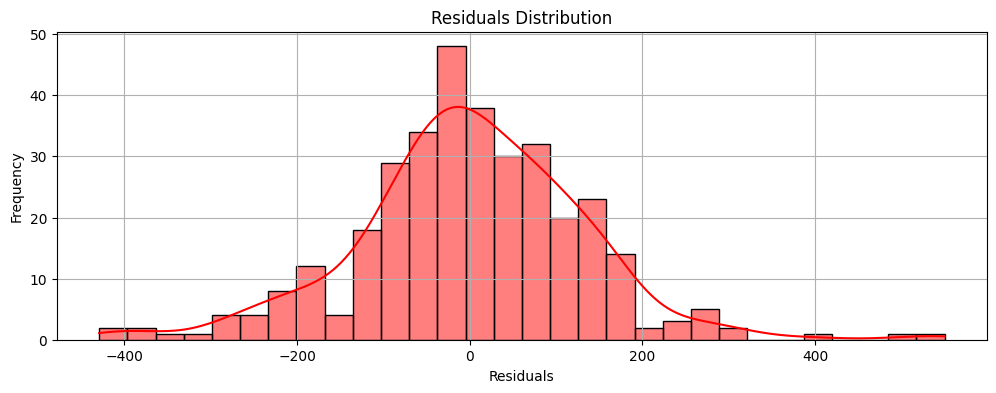

In [29]:
# Plot Residuals Distribution
plt.figure(figsize=(12, 4))
sns.histplot(error_df['Residuals'], bins=30, kde=True, color='red')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.grid()
plt.show()


In [30]:
# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(error_df['Actual'], error_df['Predicted'])

# Compute Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_actual, y_pred):
    mask = y_actual != 0  # Avoid division by zero
    return np.mean(np.abs((y_actual[mask] - y_pred[mask]) / y_actual[mask])) * 100

mape = mean_absolute_percentage_error(error_df['Actual'].values, error_df['Predicted'].values)

# Compute Weighted Mean Absolute Deviation (WMAD)
actual_values = error_df['Actual'].values
predicted_values = error_df['Predicted'].values

# Avoid division by zero by replacing zeros in actual values with a small number
actual_zero_adjusted = np.where(actual_values == 0, 1e-10, actual_values)
wmad = np.sum(np.abs(actual_values - predicted_values)) / np.sum(actual_zero_adjusted)

# Compute Average Accuracy
avg_accuracy = 1 - wmad

# Store error metrics in a DataFrame for easier reference
error_metrics = pd.DataFrame({
    'Metric': [
        'Mean Absolute Error (MAE)', 
        'Mean Absolute Percentage Error (MAPE)', 
        'Weighted Mean Absolute Deviation (WMAD)', 
        'Average Accuracy'
    ],
    'Value': [mae, mape, wmad, avg_accuracy]
})

# Print Error Metrics
print("\nError Analysis Metrics:")
print(error_metrics)



Error Analysis Metrics:
                                    Metric      Value
0                Mean Absolute Error (MAE)  97.846036
1    Mean Absolute Percentage Error (MAPE)   3.324197
2  Weighted Mean Absolute Deviation (WMAD)   0.032406
3                         Average Accuracy   0.967594


## prediction

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import joblib
import tensorflow as tf
import mysql.connector
from datetime import datetime, timedelta
import re
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load Trained Model & Scaler
model = tf.keras.models.load_model('best_model_D_lstm.h5')
scaler = joblib.load('scaler_LD.pkl')

# Load NLP Model & Sentiment Analyzer
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
analyzer = SentimentIntensityAnalyzer()

# Load Loughran-McDonald Sentiment Dictionary
lm_positive = {"gain", "growth", "bullish", "opportunity", "profit", "surge", "expansion",
    "adoption", "approval", "partnership", "innovation", "mainstream", "rally",
    "institutional", "breakthrough", "stability", "strong", "all-time-high",
    "liquidity", "halving", "scarcity", "whale accumulation", "stake", "integration",
    "etf approval", "layer 2 scaling", "metaverse expansion", "positive outlook"}

lm_negative = {"crash", "loss", "bearish", "decline", "debt", "bankruptcy", "downturn",
    "regulatory crackdown", "ban", "fud", "lawsuit", "hacked", "ponzi",
    "liquidation", "fraud", "scam", "rug pull", "dumping", "sell-off",
    "volatility", "delisting", "depeg", "inflation", "recession", "exchange insolvency",
    "crypto winter", "negative outlook"}

# Preprocessing Functions
def preprocess_text(text):
    """Cleans, removes stopwords, and lemmatizes input text."""
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  
    text = re.sub(r"[^a-zA-Z\s]", "", text)  
    text = re.sub(r"\s+", " ", text).strip()  
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

def financial_sentiment_adjustment(text, vader_score):
    """Adjust sentiment score using the Loughran-McDonald financial lexicon."""
    words = text.split()
    adjustment = sum(0.2 if word in lm_positive else -0.2 if word in lm_negative else 0 for word in words)
    return max(min(vader_score + adjustment, 1), -1)

def preprocess_news(news_data):
    """Preprocess news headlines & descriptions, and extract sentiment scores."""
    news_data["cleaned_headline"] = news_data["headline"].astype(str).apply(preprocess_text)
    news_data["cleaned_description"] = news_data["description"].astype(str).apply(preprocess_text)

    news_data["VADER_Headline_Sentiment"] = news_data["cleaned_headline"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
    news_data["VADER_Description_Sentiment"] = news_data["cleaned_description"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

    news_data["Final_Headline_Sentiment"] = news_data.apply(
        lambda row: financial_sentiment_adjustment(row["cleaned_headline"], row["VADER_Headline_Sentiment"]), axis=1
    )
    news_data["Final_Description_Sentiment"] = news_data.apply(
        lambda row: financial_sentiment_adjustment(row["cleaned_description"], row["VADER_Description_Sentiment"]), axis=1
    )

    news_data["date"] = pd.to_datetime(news_data["date"], errors="coerce")
    return news_data[["date", "Final_Description_Sentiment"]].drop_duplicates()

# Fetch Latest News Data
def fetch_latest_news():
    try:
        conn = mysql.connector.connect(
            host='localhost',
            user='root',
            password='Ariyarathne99@',
            database='crypto_news'
        )
        query = "SELECT date, headline, description FROM ethereum_news WHERE date >= CURDATE() - INTERVAL 2 DAY"
        news_data = pd.read_sql_query(query, conn)
        conn.close()

        if news_data.empty:
            # If no news today, fetch last available news
            query = "SELECT date, headline, description FROM ethereum_news ORDER BY date DESC LIMIT 1"
            conn = mysql.connector.connect(
                host='localhost',
                user='root',
                password='Ariyarathne99@',
                database='crypto_news'
            )
            last_news = pd.read_sql_query(query, conn)
            conn.close()
            news_data = last_news if not last_news.empty else pd.DataFrame(columns=["date", "headline", "description"])

        return news_data

    except mysql.connector.Error as err:
        print(f"Error fetching news: {err}")
        return pd.DataFrame(columns=["date", "headline", "description"])

news_data = fetch_latest_news()
news_data = preprocess_news(news_data)

# Get latest available sentiment (ONLY FROM DESCRIPTION)
if not news_data.empty:
    latest_sentiment = news_data["Final_Description_Sentiment"].iloc[-1]
else:
    latest_sentiment = 0  # Default sentiment if no news available

# Fetch Latest Price Data
symbol = 'ETH-USD'
window_size = 2
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=window_size + 2)).strftime('%Y-%m-%d')

price_data = yf.download(symbol, start=start_date, end=end_date, interval='1d')
price_data.reset_index(inplace=True)
price_data = price_data[['Date', 'Close']].tail(window_size)  # Take last `window_size` rows

# Convert Date to Normal Format
price_data['Date'] = pd.to_datetime(price_data['Date']).dt.date
latest_prices = price_data['Close'].values

# Prepare Data for Prediction
sentiment_input = np.array([[latest_sentiment]] * window_size)  # Repeat latest sentiment
scaled_prices = scaler.transform(np.column_stack((sentiment_input, latest_prices)))

X_input = scaled_prices[:, 1].reshape(1, window_size, 1)  # Closing prices
sentiment_input = np.array([[latest_sentiment]]).reshape(1, 1, 1)  # Single latest sentiment score

# Combine Inputs
X_input = np.concatenate((X_input, sentiment_input), axis=1)

# Predict Next Day's Price
predicted_scaled_price = model.predict(X_input)
predicted_price = scaler.inverse_transform([[0, predicted_scaled_price[0][0]]])[0][1]

# Save Prediction
prediction_date = datetime.today().strftime('%Y-%m-%d')
print(f"Predicted Closing Price for {symbol} on {prediction_date}: ${predicted_price:.4f}")


C:\Users\acer\AppData\Local\Temp\ipykernel_7508\1174178604.py:79: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  news_data = pd.read_sql_query(query, conn)
C:\Users\acer\AppData\Local\Temp\ipykernel_7508\1174178604.py:91: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  last_news = pd.read_sql_query(query, conn)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
C:\Users\acer\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Predicted Closing Price for ETH-USD on 2025-03-24: $1960.2430
